In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
data = "../data/robot_data.csv"


In [3]:
df = pd.read_csv(data,header=None, names=['wheel_l','wheel_r','beta_l','beta_r','alpha', 'i', 'j'])

In [4]:
df

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,13.667083,15.014833,0.910432,1.025692,0.000000,4.0,4.0
1,3.989922,5.276173,-0.069388,-0.021717,-0.003247,5.0,3.0
2,13.434004,14.772097,0.865255,0.979679,0.000000,4.0,1.0
3,14.604564,15.942049,1.006339,1.120739,0.000000,3.0,0.0
4,3.381492,4.574070,-0.010082,0.005127,0.000000,1.0,1.0
...,...,...,...,...,...,...,...
935,3.245135,4.250640,-0.005125,0.005139,0.000000,3.0,5.0
936,3.243161,4.250255,-0.005009,0.005065,-0.005762,4.0,4.0
937,3.242076,4.252297,-0.005160,0.005174,0.000000,5.0,2.0
938,3.244541,4.255521,-0.005044,0.005084,-0.004324,4.0,1.0


In [5]:
i_filter = 3
j_filter = 0

In [6]:
filtered = df[(df.i == i_filter) & (df.j == j_filter)]
filtered

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
3,14.604564,15.942049,1.006339,1.120739,0.000000,3.0,0.0
8,11.169409,12.989319,0.460288,0.615897,0.000000,3.0,0.0
27,3.112592,4.816755,-0.008202,0.008432,-0.022018,3.0,0.0
32,3.215615,4.697971,-0.007333,0.007346,-0.016327,3.0,0.0
37,3.281239,4.600027,-0.006605,0.006501,-0.012222,3.0,0.0
...,...,...,...,...,...,...,...
919,3.252599,4.263266,-0.005028,0.005079,-0.005819,3.0,0.0
924,3.255037,4.261844,-0.005009,0.005060,-0.005755,3.0,0.0
929,3.255788,4.262295,-0.005011,0.005062,-0.005743,3.0,0.0
934,3.254794,4.264788,-0.005033,0.005086,-0.005787,3.0,0.0


In [7]:
# Example data
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values

# Initial OLS regression to get residuals
X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ beta_l)
beta_l_hat_ols = X @ theta_hat_ols
residuals_ols = beta_l - beta_l_hat_ols

# Estimate weights as the inverse of the squared residuals
weights = 1 / (residuals_ols ** 2)

# Now use these weights in the WLS estimation
W = np.diag(weights)
XTWX_inv = np.linalg.inv(X.T @ W @ X)
XTWy = X.T @ W @ beta_l
theta_hat_wls = XTWX_inv @ XTWy

# Estimated coefficients from WLS
theta_0, theta_1, theta_2 = theta_hat_wls
print("WLS Estimated coefficients:", theta_hat_wls)


WLS Estimated coefficients: [-0.17061293  0.11932017 -0.05197438]


In [8]:
def model(x,theta):
    return theta[0] + theta[1] * x[...,0] + theta[2] * x[...,1]

In [9]:
x = filtered[["wheel_l", "wheel_r"]].values
y = filtered.beta_l.values

In [10]:
y_hat = model(x, theta_hat_wls)

In [49]:
y_hat_ols = model(x, theta_hat_ols)

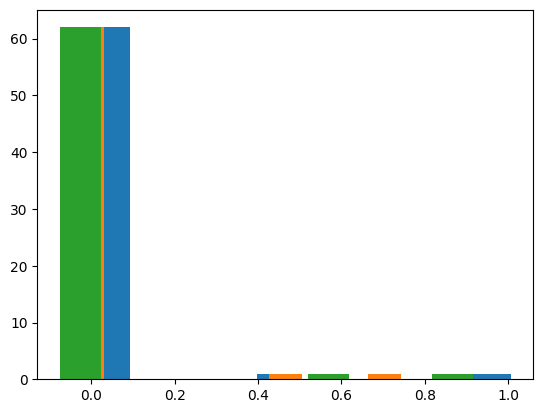

In [51]:
plt.hist(y)
plt.hist(y_hat)
plt.hist(y_hat_ols)
plt.show()

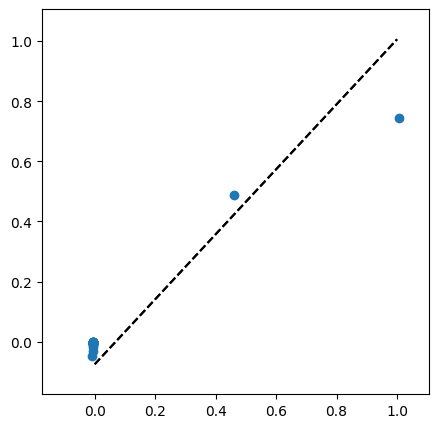

In [55]:
y_min = min(y.min(),y_hat.min(),y_hat_ols.min())
y_max = max(y.max(),y_hat.max(),y_hat_ols.max())
plt.figure(figsize=(5,5))
plt.xlim(y_min-0.1,y_max+0.1)
plt.ylim(y_min-0.1,y_max+0.1)
plt.scatter(y,y_hat)
plt.plot([[y_min,y_min],[y_max,y_max]], "--", color='black')
plt.show()

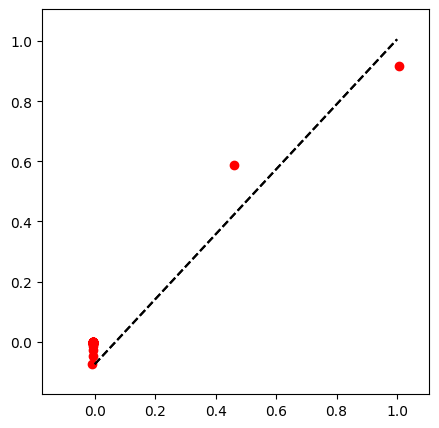

In [57]:
y_min = min(y.min(),y_hat.min(),y_hat_ols.min())
y_max = max(y.max(),y_hat.max(),y_hat_ols.max())
plt.figure(figsize=(5,5))
plt.xlim(y_min-0.1,y_max+0.1)
plt.ylim(y_min-0.1,y_max+0.1)
plt.scatter(y,y_hat_ols, color="red")
plt.plot([[y_min,y_min],[y_max,y_max]], "--", color='black')
plt.show()

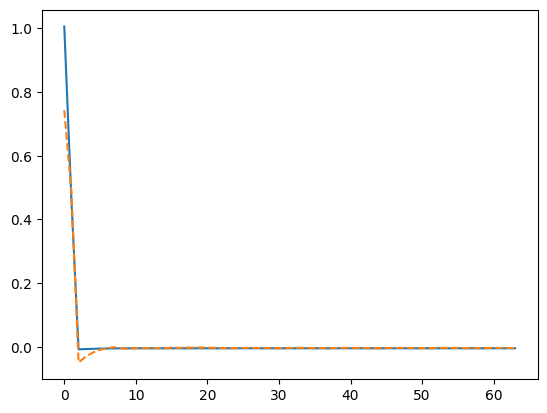

In [58]:
plt.plot(y)
plt.plot(y_hat, '--')
plt.show()

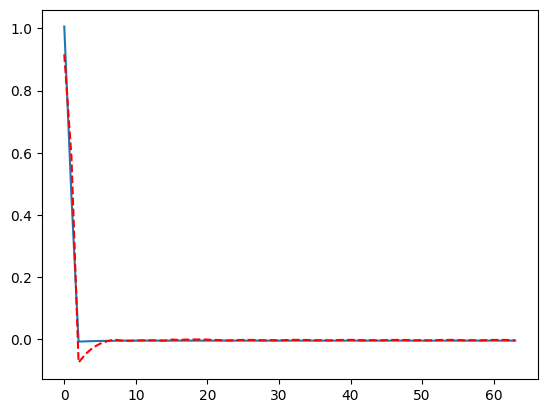

In [59]:
plt.plot(y)
plt.plot(y_hat_ols, '--', color="red")
plt.show()

In [61]:
r2_score(y, y_hat), r2_score(y, y_hat_ols)

(0.9399973044749715, 0.9741757241894593)